In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore')



In [2]:
DATA_DIR = 'content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)


In [3]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")


Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [4]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")


Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [5]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('int')
    cl['disrict'] = cl['disrict'].astype('int')
    cl['region'] = cl['region'].astype('int')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [6]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)

In [7]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [8]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)

In [9]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [10]:
train_df2 = new_features(train_df1)

In [11]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))



Initial number of columns:  29
Number of columns now:  111


In [12]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [13]:
train_df = drop(train_df2)

In [14]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [15]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)

## Model

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report, f1_score, recall_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# bin numerical data, scale data, encode data
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, OneHotEncoder  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

# XGBoost model
#-------------------------------------------------------
import xgboost as xgb
from xgboost import XGBClassifier

# LGBM model
#-------------------------------------------------------
import lightgbm
from lightgbm import LGBMClassifier

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=777, test_size=0.2)

Recall-score = 0.2048909451421018, F1-score = 0.30097087378640774


## Grid search

In [94]:
%%time
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from scipy.stats import uniform, truncnorm, randint

# Create the parameters list you wish to tune
parameters = {'n_estimators':randint(0, 1000),
              'num_leaves': randint(2, 512),
              'max_depth': randint(2, 128),
              'learning_rate':uniform(0.001, 0.15),
              'min_split_gain': uniform(0.001, 0.1),
              'feature_fraction': uniform(0.1, 1.0),
              'bagging_freq': randint(1,10),
              'verbosity': [-1],
              'random_state':[777]
             } 

# Make an fbeta_score scoring object
scorer = make_scorer(recall_score) 


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
gridsearch = RandomizedSearchCV(lgbm_model, param_distributions = parameters, cv=2, n_iter=1000, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters

gridsearch.fit(X_train, y_train)


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-980pbj3x/lightgbm_3ba115fcc85344d4af4dd9a6e1e7ec36/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-980pbj3x/lightgbm_3ba115fcc85344d4af4dd9a6e1e7ec36/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-980pbj3x/lightgbm_3ba115fcc85344d4af4dd9a6e1e7ec36/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-980pbj3x/lightgbm_3ba115fcc85344d4af4dd9a6e1e7ec36/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-980pbj3x/lightgbm_3ba115fcc85344d4af4dd9a6e1e7ec36/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-980pbj3x/lightgbm_3ba115fcc85344d4af4dd9a6e1e7ec36/src/io/config_auto.cpp, line

CPU times: user 14h 19min 56s, sys: 7min 31s, total: 14h 27min 28s
Wall time: 7h 18min 57s


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_iter=1000,
                   param_distributions={'bagging_freq': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f89df07c990>,
                                        'feature_fraction': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f89df07d510>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen objec...
                                        'min_split_gain': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f89df07dc90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f89df07fe90>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f89df07d9d0>,
                                        'random_state': [777],
                                        'verbosity': [-1]},
                   scoring=make_scorer(recall_score))

In [96]:
gridsearch.best_score_

0.20056187417450916

In [109]:
gridsearch.best_params_

{'bagging_freq': 9,
 'feature_fraction': 0.8868734928852935,
 'learning_rate': 0.14008271018554203,
 'max_depth': 59,
 'min_split_gain': 0.05123048228199154,
 'n_estimators': 876,
 'num_leaves': 16,
 'random_state': 777,
 'verbosity': -1}

## Model with best parameters

Recall-score = 0.2048909451421018, F1-score = 0.30097087378640774


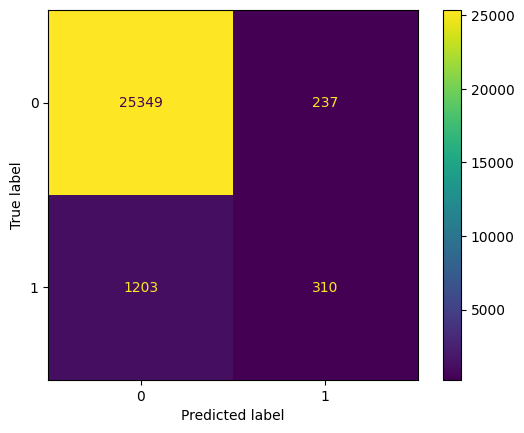

In [110]:
lgbm_model = LGBMClassifier(
    bagging_freq= 9,
    feature_fraction = 0.8868734928852935,
     learning_rate = 0.14008271018554203,
     max_depth = 59,
     min_split_gain = 0.05123048228199154,
     n_estimators = 876,
     num_leaves = 16,
     random_state = 777,
     verbosity = -1)

lgbm_model.fit(X_train, y_train)

y_pred = lgbm_model.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

print(f"Recall-score = {recall_score(y_test, y_pred) }, F1-score = {f1_score(y_test, y_pred)}")




Recall-score = 0.12029081295439524, F1-score = 0.18543046357615894


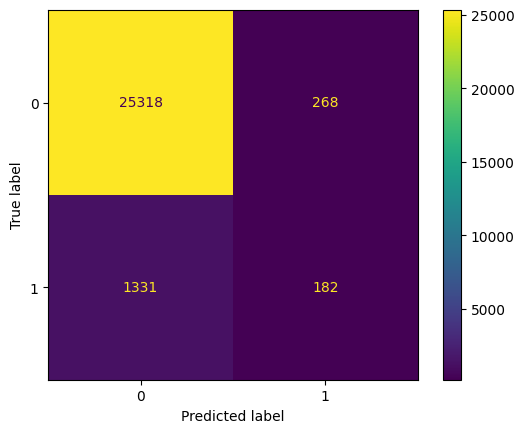

In [116]:
model = KNeighborsClassifier(metric='chebyshev')

model.fit(X_train.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_train)

y_pred = model.predict(X_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False))

ConfusionMatrixDisplay(confusion_matrix(y_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_pred)).plot()

print(f"Recall-score = {recall_score(y_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_pred) }, F1-score = {f1_score(y_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_pred)}")



In [117]:
model = KNeighborsClassifier(metric='cosine')

model.fit(X_train.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_train)

y_pred = model.predict(X_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False))

ConfusionMatrixDisplay(confusion_matrix(y_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_pred)).plot()

print(f"Recall-score = {recall_score(y_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_pred) }, F1-score = {f1_score(y_test.fillna(0).replace([np.inf, -np.inf], 0, inplace=False), y_pred)}")



MemoryError: Unable to allocate 1.00 GiB for an array with shape (1238, 108394) and data type int64